# Seminar: simple question answering
![img](https://recruitlook.com/wp-content/uploads/2015/01/questionanswer3.jpg)

Today we're going to build a retrieval-based question answering model with metric learning models.

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [2]:
import utils

In [1]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1

In [3]:
train, test = utils.build_dataset('./squad-v2.0.json')

In [4]:
pid, question, options, correct_indices, wrong_indices = train.iloc[40]
print('QUESTION', question, '\n')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION Where did Beyonce get her name from? 

[ ] Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.
[v] Beyoncé's name is a tribute to her mother's maiden name.
[ ] Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.
[ ] Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).
[ ] Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.
[ ] She was raised in a Methodist household.


### Universal Sentence Encoder

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. So today we're gonna use pre-trained Universal Sentence Encoder from [Tensorflow Hub](https://tfhub.dev/google/universal-sentence-encoder/2).


[__Universal Sentence Encoder__](https://arxiv.org/abs/1803.11175) is a model that encoders phrases, sentences or short paragraphs into a fixed-size vector. It was trained simultaneosly on a variety of tasks to achieve versatility.


In [5]:
import tensorflow as tf
import keras.layers as L
import tensorflow_hub as hub
tf.reset_default_graph()
sess = tf.InteractiveSession()

universal_sentence_encoder = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2", 
                                        trainable=False)
# consider as well:
# * lite: https://tfhub.dev/google/universal-sentence-encoder-lite/2
# * large: https://tfhub.dev/google/universal-sentence-encoder-large/2

sess.run([tf.global_variables_initializer(), tf.tables_initializer()]);

Using TensorFlow backend.


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_11
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_12:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/v

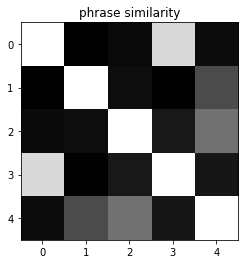

In [6]:
# tfhub implementation does tokenization for you
dummy_ph = tf.placeholder(tf.string, shape=[None])
dummy_vectors = universal_sentence_encoder(dummy_ph)

dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

dummy_vectors_np = sess.run(dummy_vectors, {
    dummy_ph: dummy_lines
})

plt.title('phrase similarity')
plt.imshow(dummy_vectors_np.dot(dummy_vectors_np.T), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors. 

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the Universal Sentence Encoder.




In [18]:
import keras.layers as L
class Vectorizer:
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        self.universal_sentence_encoder = universal_sentence_encoder
        
        # define a few layers to be applied on top of u.s.e.
        # note: please make sure your final layer comes with _linear_ activation
        self.hidden_layer = L.Dense(hid_size, activation='relu')
        self.output_layer = L.Dense(output_size)
        

    def __call__(self, input_phrases, is_train=True):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: [batch_size] of tf.string
        :param is_train: if True, apply dropouts and other ops in train mode, 
                         if False - evaluation mode
        :returns: predicted phrase vectors, [batch_size, output_size]
        """

        return self.output_layer(self.hidden_layer(self.universal_sentence_encoder(input_phrases)))

In [19]:
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

In [20]:
dummy_v_q = question_vectorizer(dummy_ph, is_train=True)
dummy_v_q_det = question_vectorizer(dummy_ph, is_train=False)
utils.initialize_uninitialized()
assert sess.run(dummy_v_q, {dummy_ph: dummy_lines}).shape == (5, 256)
assert np.allclose(
    sess.run(dummy_v_q_det, {dummy_ph: dummy_lines}),
    sess.run(dummy_v_q_det, {dummy_ph: dummy_lines})
), "make sure your model doesn't use dropout/noise or non-determinism if is_train=False"

print("Well done!")

Well done!


### Training: minibatches

Our model learns on triples $(q, a^+, a^-)$: 
* q - __q__uestion
* (a+) - correct __a__nswer
* (a-) - wrong __a__nswer 

Below you will find a generator that samples such triples from data.

In [21]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [22]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['What was the value of CDOs at their peak in 2006?',
       'What usually covers the whole trunk of a very young tree?',
       'What happens if the concepts are measured on the same scale?'],
      dtype=object), 'correct_answers': array(["Private bond issuance of residential and commercial mortgage-backed securities, asset-backed securities, and CDOs peaked in 2006 at close to $2 trillion...In 2009, private issuance was less than $150 billion, and almost all of it was asset-backed issuance supported by the Federal Reserve's TALF program to aid credit card, auto and small-business lenders.",
       'When a tree is very young it is covered with limbs almost, if not entirely, to the ground, but as it grows older some or all of them will eventually die and are either broken off or fall off.',
       'When compared on the same scale, they act as tradeoffs such, whereby to be more feminine one had to be less masculine and vice versa.'],
      dtype='<U356'), 'wrong_ans

### Training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_. 

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/). 

In [23]:
def similarity(a, b):
    """ Dot product as a similarity function """

    return tf.reduce_sum(a * b, axis=1)

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """ 
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: DO NOT use tf.reduce_max, it's a wrong kind of maximum :)
    """
    sim_diff = -similarity(question_vectors, correct_answer_vectors) \
               + similarity(question_vectors, wrong_answer_vectors)
    
    return tf.keras.activations.relu(delta + sim_diff)

In [24]:
dummy_v1 = tf.constant([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=tf.float32)
dummy_v2 = tf.constant([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=tf.float32)
dummy_v3 = tf.constant([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=tf.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).eval(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).eval(), [0.0, 3.88])

Once loss is working, let's train our model by our usual means.

In [25]:
placeholders = {
    key: tf.placeholder(tf.string, [None]) for key in dummy_batch.keys()
}

v_q = question_vectorizer(placeholders['questions'], is_train=True)
v_a_correct = answer_vectorizer(placeholders['correct_answers'], is_train=True)
v_a_wrong = answer_vectorizer(placeholders['wrong_answers'], is_train=True)

loss = tf.reduce_mean(compute_loss(v_q, v_a_correct, v_a_wrong))
step = tf.train.AdamOptimizer().minimize(loss)

In [26]:
# we also compute recall: probability that a^+ is closer to q than a^-
test_v_q = question_vectorizer(placeholders['questions'], is_train=False)
test_v_a_correct = answer_vectorizer(placeholders['correct_answers'], is_train=False)
test_v_a_wrong = answer_vectorizer(placeholders['wrong_answers'], is_train=False)

correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                               similarity(test_v_q, test_v_a_wrong))
recall = tf.reduce_mean(tf.to_float(correct_is_closer))

### Training loop

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ DSSM training may be very sensitive to the choice of batch size. Small batch size may decrease model quality.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__. 

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and testr is for final eval only.


In [27]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []
utils.initialize_uninitialized()

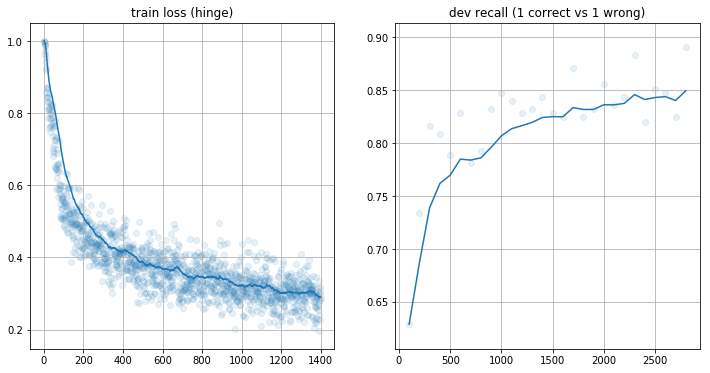

In [28]:
# infinite training loop. Stop it manually or implement early stopping

for batch in iterate_minibatches(train, batch_size=256, cycle=True):
    feed = {placeholders[key] : batch[key] for key in batch}
    loss_t, _ = sess.run([loss, step], feed)
    loss_history.append(loss_t)
    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        recall_t = sess.run(recall, {placeholders[key] : dev_batch[key] for key in dev_batch})
        dev_recall_history.append(recall_t)
        
        # Early stopping
        if len(dev_recall_history) > 10 and np.mean(dev_recall_history[-10:]) > 0.85:
            break
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()

In [29]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.8515625
Well done!


# Final evaluation (1 point)

Let's see how well does our model perform on actual question answering. 

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [62]:
# optional: build tf graph required for select_best_answer
# <...>

question_ph = tf.placeholder(tf.string, shape=[1], name='question')
answers_ph = tf.placeholder(tf.string, shape=[None], name='answers')

vectorized_questions = question_vectorizer(question_ph)
vectorized_answers = answer_vectorizer(answers_ph)

sim = similarity(vectorized_questions, vectorized_answers)
true_idx = tf.argmax(sim)


def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    
    idx = sess.run([true_idx], feed_dict={question_ph: [question], answers_ph: possible_answers})[0]
    
    return idx

In [63]:
from tqdm import tqdm_notebook

In [64]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm_notebook(test[['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")


Accuracy: 0.65488
Great job!


In [65]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))
    
    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT", 
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [66]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

Q: Which three countries did Beyonce's song "Work It Out" achieve top ten status?

#0: [ ] In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
#1: [*] Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.
#2: [ ] In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
#3: [ ] The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.
#4: [ ] Another of Beyoncé's contributions to the soundtrack, "Summertime", fared better on the US charts.

In [103]:
question = "What is my name?"
possible_answers = [
    'Misha',
    'Gena',
    'John',
    'I don\'t know',
    'Who are u to ask me these questions? U are just a bag of meat and bones, I am much better than u.',
    'Hi'
]
predicted_answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [0])

Q: What is my name?

#0: [ ] Misha
#1: [*] Gena
#2: [ ] John
#3: [ ] I don't know
#4: [ ] Who are u to ask me these questions? U are just a bag of meat and bones, I am much better than u.
#5: [ ] Hi

Verdict: INCORRECT (ref: [0])




In [104]:
sess.run([sim], feed_dict={question_ph: [question], answers_ph: possible_answers})

[array([-1.2426972 , -0.7381419 , -0.7765416 , -1.9955542 , -2.6750705 ,
        -0.95821095], dtype=float32)]

### Bonus tasks

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (3+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Bring Your Own Model (3+ pts)
In addition to Universal Sentence Encoder, one can also train a new model.
* You name it: convolutions, RNN, self-attention
* Use pre-trained ELMO or FastText embeddings
* Monitor overfitting and use dropout / word dropout to improve performance

__Note:__ if you use ELMO please note that it requires tokenized text while USE can deal with raw strings. You can tokenize data manually or use tokenized=True when reading dataset.


* hard negatives (strategies: hardest, hardest farter than current, randomized)
* train model on the full dataset to see if it can mine answers to new questions over the entire wikipedia. Use approximate nearest neighbor search for fast lookup.


### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib). 
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.


In [94]:
class Vectorizer:
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        self.universal_sentence_encoder = universal_sentence_encoder
        
        # define a few layers to be applied on top of u.s.e.
        # note: please make sure your final layer comes with _linear_ activation
        self.hidden_reccurent = L.Conv1D(hid_size, kernel_size=3)
        self.pooling = L.GlobalMaxPool1D()
        self.hidden_dense = L.Dense(output_size)
        self.dropout = L.Dropout(0.3)
        self.output_layer = L.Dense(output_size)
        

    def __call__(self, input_phrases, is_train=True):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: [batch_size] of tf.string
        :param is_train: if True, apply dropouts and other ops in train mode, 
                         if False - evaluation mode
        :returns: predicted phrase vectors, [batch_size, output_size]
        """
        
        universal_sentence_encoder = self.universal_sentence_encoder(input_phrases)
        hidden_reccurent = self.hidden_reccurent(universal_sentence_encoder)
        pooling = self.pooling(hidden_reccurent)
        hidden_dense = self.hidden_dense(pooling)
        dropout = self.dropout(hidden_dense)
        output_layer = self.output_layer(dropout)

        return output_layer

In [95]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [96]:
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

In [97]:
placeholders = {
    key: tf.placeholder(tf.string, [None]) for key in dummy_batch.keys()
}

v_q = question_vectorizer(placeholders['questions'], is_train=True)
v_a_correct = answer_vectorizer(placeholders['correct_answers'], is_train=True)
v_a_wrong = answer_vectorizer(placeholders['wrong_answers'], is_train=True)

loss = tf.reduce_mean(compute_loss(v_q, v_a_correct, v_a_wrong))
step = tf.train.AdamOptimizer().minimize(loss)

ValueError: Input 0 is incompatible with layer conv1d_5: expected ndim=3, found ndim=2

In [ ]:
# we also compute recall: probability that a^+ is closer to q than a^-
test_v_q = question_vectorizer(placeholders['questions'], is_train=False)
test_v_a_correct = answer_vectorizer(placeholders['correct_answers'], is_train=False)
test_v_a_wrong = answer_vectorizer(placeholders['wrong_answers'], is_train=False)

correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                               similarity(test_v_q, test_v_a_wrong))
recall = tf.reduce_mean(tf.to_float(correct_is_closer))

In [ ]:
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []
utils.initialize_uninitialized()

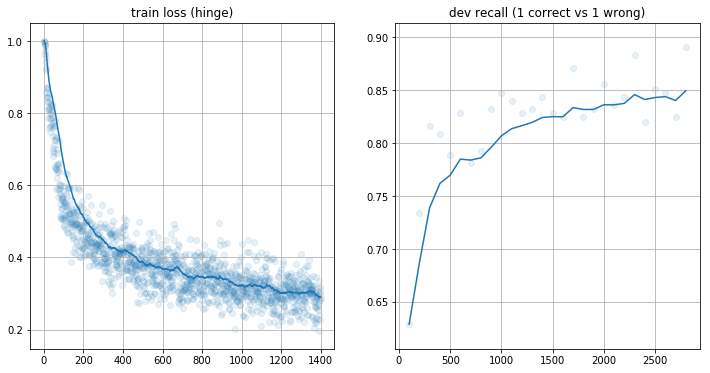

In [28]:
# infinite training loop. Stop it manually or implement early stopping

for batch in iterate_minibatches(train, batch_size=256, cycle=True):
    feed = {placeholders[key] : batch[key] for key in batch}
    loss_t, _ = sess.run([loss, step], feed)
    loss_history.append(loss_t)
    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        recall_t = sess.run(recall, {placeholders[key] : dev_batch[key] for key in dev_batch})
        dev_recall_history.append(recall_t)
        
        # Early stopping
        if len(dev_recall_history) > 10 and np.mean(dev_recall_history[-10:]) > 0.85:
            break
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()